# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [2]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print 'data shape: ', X.shape
print 'label shape:', Y.shape

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

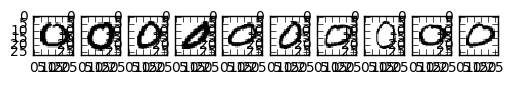

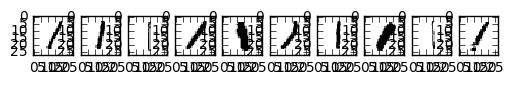

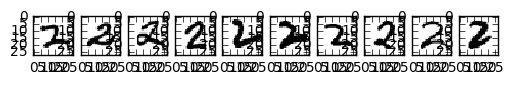

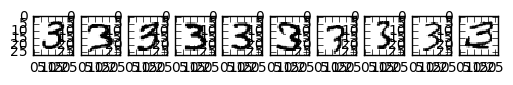

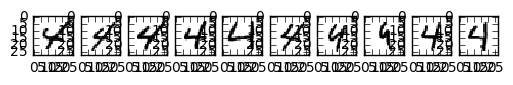

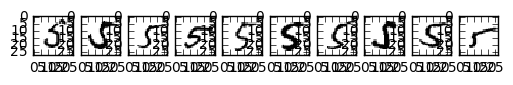

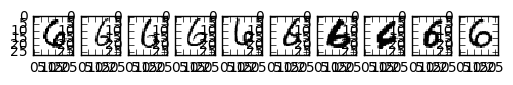

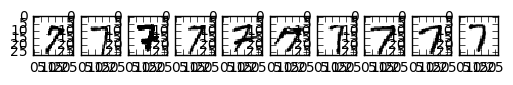

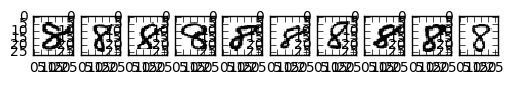

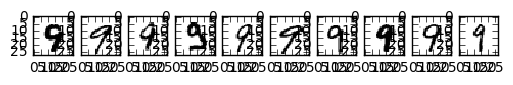

In [3]:
# Search the labels array (Y) to find the indices of the first 'num_examples' of each digit
def find_example_digits(num_examples):
    digit_lists = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
    i = 0
    while True:
        # if less than 'num_examples' indices found append i to digit_lists
        if len(digit_lists[int(Y[i])]) < num_examples:
            digit_lists[int(Y[i])].append(i)
        # when 'num_examples' digits found for all 10 different digits end the search
        if sum([1 for j in range(10) if len(digit_lists[j]) == num_examples]) == 10:
            break
        i += 1
    return digit_lists

# Take a 'digit' vector as input and convert to a grayscale matrix
# Note for printing I have inverted the colors, so the digit is black and background white
def pre_process_digit(digit):
    # reshape pixel array into a 28x28 matrix
    x = digit.reshape((28,28))
    # switch the grayscale, so the digit is black
    x = 1 - x
    return x

# Generic print function to print a group of digits
def print_digits(data, indices, num_plt_row):
    plot_num = 1
    for i in range(len(indices)):
        x, y = divmod(len(indices), num_plt_row)
        if y == 0:
            rows = x
        else:
            rows = x + 1
        P = pre_process_digit(data[indices[i]])
        plt.subplot(rows, num_plt_row, plot_num)
        plt.imshow(P,interpolation='nearest',cmap='gray')
        plot_num += 1
    plt.show()

def P1(num_examples=10):
    # get the indices for the example digits
    digit_idx = find_example_digits(num_examples)                            
    # run loop to print each digit group
    for i in range(10):
        print_digits(X, digit_idx[i], 10)
                        
P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [4]:
# A generic classfier procedure to reduce code repetition in other questions
def run_clf(train_X, train_y, test_X, test_y, classifier, **kwargs):
    # create classifier with defined arguments
    clf = classifier(**kwargs)
    # fit the classifier on the training data
    clf.fit(train_X, train_y)
    # produce predictions on the test data and capture speed of the predictions
    t0 = time.time()
    predictions = clf.predict(test_X)
    t1 = time.time()
    speed = t1-t0
    # calculate accuracy of the predictions
    correct = 0
    correct += np.sum(predictions==test_y)
    total = len(test_y)
    accuracy = float(correct)/float(total)
    # produce a classification report for the predictions
    clf_report = classification_report(test_y, predictions)
    # produce confusion matrix for the predictions
    confusion = confusion_matrix(test_y, predictions)
    # collate output statistics in the 'stats' dict
    stats = {'preds': predictions, 'accuracy': accuracy, 'speed': speed, 'clf_report': clf_report, 'confusion': confusion}
    return clf, stats # return the classifier and its stats

# A generic output report to visualise the results
def clf_output(stats):
    print "Classification report:"
    print stats['clf_report']
    print "Confusion matrix:"
    print stats['confusion']
    print ""

def P2(k_values):
    # Run classifier for each value in k_values and report results
    for k in k_values:
        clf, stats = run_clf(mini_train_data, mini_train_labels, dev_data, dev_labels, KNeighborsClassifier, n_neighbors=k)
        print "k-nearest-neighbors: " + str(k)
        print "accuracy: " + str(stats['accuracy']) + "\n"
        clf_output(stats)
    return
        
k_values = [1, 3, 5, 7, 9]
P2(k_values)

k-nearest-neighbors: 1
accuracy: 0.888

Classification report:
             precision    recall  f1-score   support

        0.0       0.91      0.98      0.94        99
        1.0       0.89      1.00      0.94       105
        2.0       0.99      0.79      0.88       102
        3.0       0.77      0.87      0.82        86
        4.0       0.89      0.82      0.85       104
        5.0       0.93      0.84      0.88        91
        6.0       0.94      0.96      0.95        98
        7.0       0.89      0.92      0.90       113
        8.0       0.94      0.88      0.91        96
        9.0       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000

Confusion matrix:
[[ 97   0   0   0   0   0   2   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  4   4  81   4   0   0   0   4   3   2]
 [  1   0   0  75   0   3   0   3   1   3]
 [  0   2   0   0  85   0   3   0   0  14]
 [  2   0   0   9   0  76   0   1   1   2]
 [  1   1   1   0   1 

ANSWER: The results of this analysis show that a k-nearest neighbours model with k=1 produces the best accuracy in the dev_data set. Overall the most difficult digit using the nearest neighbour classifier is number 9. In general it has the lowest F1 score across the values of k in k_values (including for k=1 the parameter of primary interest). Its F1 scores are fairly equally weighted between precision and recall. That is, when 9 is predicted it is generally only successful with a probability of around 0.8 (precision) and when 9 is the true label it also only succesfully predicts 9 with around a 0.8 probability (recall). Confusion matrices show that confusion involving the number 9 most commonly involves the number 4, followed by the number 7 and to a lesser degree the number 3.

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [5]:
train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
# initialise empty list for accuracy results for each train_size data set
accuracies = []

def P3(train_sizes, accuracies):
    # initialise empty list for time results for each train_size data set
    times = []
    for size in train_sizes:
        # run classifier
        clf, stats = run_clf(X[:size], Y[:size], dev_data, dev_labels, KNeighborsClassifier, n_neighbors=1)
        # collate accuracy and time results
        accuracies.append(stats['accuracy'])
        times.append(round(stats['speed'],4))

    print "train sizes: ", train_sizes
    print "accuracies: ", accuracies
    print "times: ", times
    return accuracies, times
    
accuracies, times = P3(train_sizes, accuracies)

train sizes:  [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies:  [0.72, 0.786, 0.841, 0.884, 0.902, 0.926, 0.937, 0.959, 0.97]
times:  [0.1135, 0.2033, 0.4504, 0.8489, 2.6397, 3.4189, 6.7396, 13.6531, 27.5181]


COMMENT: The main observations about these results are:
        
(1) Accuracy rises as the size of the training set rises because with more data the likelihood of closer nearest neighbours being found likely rises, and

(2) Time increases with size of the training data set.

Adding to these observations I have plotted the relationship between accurcy and time against the training set sizes below. This further highlights that:

(1) Accuracy improves as the training set rises, but at an exponentially decreasing rate, i.e. you need increasingly more data to improve accruacy by increassingly smaller amounts.

(2) While the k-nearest-neighbours model must calculate a distance metric for each observation in the training data set, so it runs in O(n) time, i.e. processing time increases linearly with training set size.    

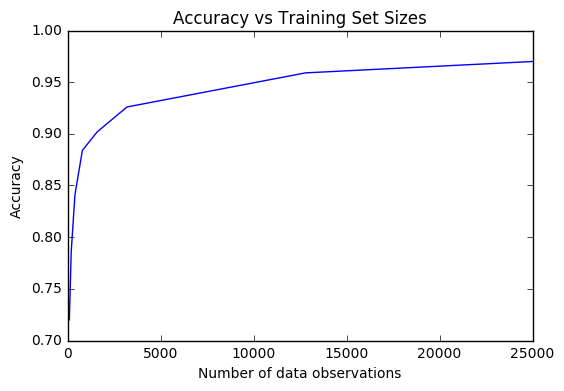

In [6]:
plt.plot(train_sizes, accuracies)
plt.title("Accuracy vs Training Set Sizes")
plt.xlabel("Number of data observations")
plt.ylabel("Accuracy")
plt.show()

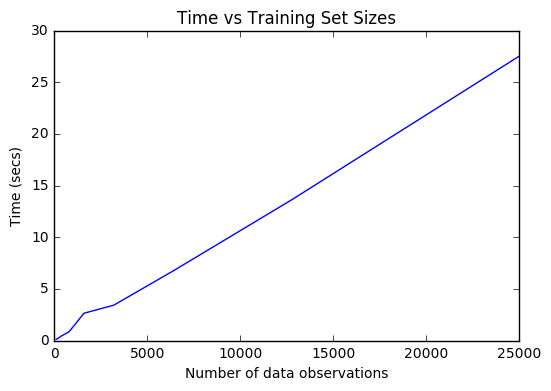

In [7]:
plt.plot(train_sizes, times)
plt.title("Time vs Training Set Sizes")
plt.xlabel("Number of data observations")
plt.ylabel("Time (secs)")
plt.show()

(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

In [8]:
# Convert regressor lists to numpy arrays and reshape as [n_samples,n_features] for use in LinearRegression
np_accuracies = np.asarray(accuracies).reshape(-1,1)
np_train_sizes = np.asarray(train_sizes).reshape(-1,1)
# Noting the exponential relationship between training size and accuracy perform a log transformation 
log_train_sizes = np.log(np_train_sizes)
# Confirm reshape has resulted in correctly shaped vectors
print np_accuracies.shape
print np_train_sizes.shape

(9, 1)
(9, 1)


____________________________________________________________________________________________________
Linear regression results on the raw data:
slope:  6.67e-06
intecept:  0.843


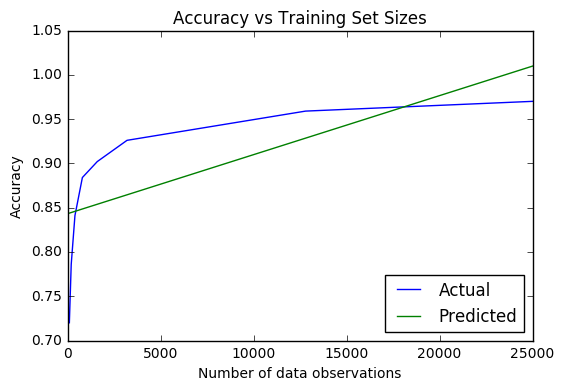

Prediction for training set size: 60000 = 1.243

____________________________________________________________________________________________________
Linear regression results on the log transformed training size data:
slope:  0.04226926
intecept:  0.569


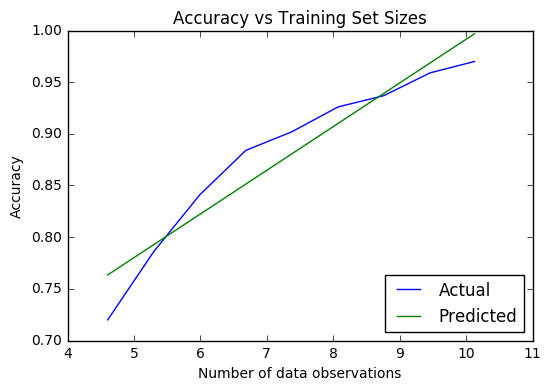

Prediction for training set size: 60000 = 1.034


In [9]:
def accuracy_prediction(X,y,pred):
    # Fit a LinearRegression model and produce a prediction
    LR = LinearRegression()
    LR.fit(X,y)
    # Retrieve slope and intercept results
    print "slope: ", round(LR.coef_[0][0],8)
    print "intecept: ", round(LR.intercept_[0],3)
    # Retrieve the set of predicted y values
    predictions = LR.predict(X)
    # Plot actual against predicted 
    line1, = plt.plot(X, np_accuracies, label='Actual')
    line2, = plt.plot(X, predictions, label='Predicted')
    plt.title("Accuracy vs Training Set Sizes")
    plt.xlabel("Number of data observations")
    plt.ylabel("Accuracy")
    plt.legend(handles=[line1, line2],loc='lower right')
    plt.show()
    return LR.predict(pred)[0][0]
    
def P4():
    print "_" * 100
    print "Linear regression results on the raw data:"
    pred1 = accuracy_prediction(np_train_sizes,np_accuracies,60000)
    print "Prediction for training set size: 60000 =", round(pred1,3)
    print ""
    print "_" * 100
    print "Linear regression results on the log transformed training size data:"
    pred2 = accuracy_prediction(log_train_sizes,np_accuracies,np.log(60000))
    print "Prediction for training set size: 60000 =", round(pred2,3)
    
P4()

ANSWER: Running the regression on the raw data is problematic because as seen in Q3 as the training set sizes increase the accuracy of the model is bounded at 1 or 100%, whereas fitting a linear relationship assumes that accuracy rises indefinitely as the training set size increases. Accordingly, the linear regression on the raw data predicts an accuracy of 124.3% for the model with a training set size of 60,000, which is obviously not possible given maximum accuracy of 100%. As highlighted in Q3 there is an exponential relationship between accuracy and training set size, so to allow for this I have applied a simple log tranform on the training size data set. Applying this simple transformation results in a 'more realistic' accuracy prediction of 103.4%, albeit this is still above a valid 100%. The results serves to illustrate the model will likely become more accurate by adding increasing more data to the training data set. 

(5) Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

Classification report:
             precision    recall  f1-score   support

        0.0       0.91      0.98      0.94        99
        1.0       0.89      1.00      0.94       105
        2.0       0.99      0.79      0.88       102
        3.0       0.77      0.87      0.82        86
        4.0       0.89      0.82      0.85       104
        5.0       0.93      0.84      0.88        91
        6.0       0.94      0.96      0.95        98
        7.0       0.89      0.92      0.90       113
        8.0       0.94      0.88      0.91        96
        9.0       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000

Confusion matrix:
[[ 97   0   0   0   0   0   2   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  4   4  81   4   0   0   0   4   3   2]
 [  1   0   0  75   0   3   0   3   1   3]
 [  0   2   0   0  85   0   3   0   0  14]
 [  2   0   0   9   0  76   0   1   1   2]
 [  1   1   1   0   1   0  94   0   0   0]
 [  1   4   0   1  

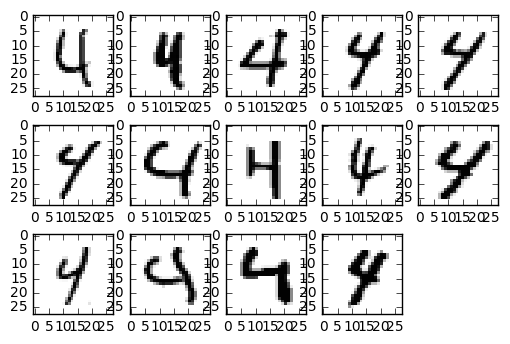

9's confused as 4's:


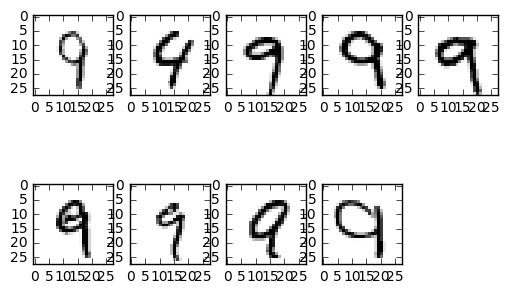

In [10]:
def P5():
    # Run the 1-NN classifier 
    clf, stats = run_clf(mini_train_data, mini_train_labels, dev_data, dev_labels, KNeighborsClassifier, n_neighbors=1)
    clf_output(stats)
    # create list of actual, predicted pairs to identify confusions
    confused = zip(dev_labels, stats['preds'])
    x, y = 4.0, 9.0
    # print out 4's that were predicted as 9's
    print "4's confused as 9's:"
    confused_idx = [i for i in range(len(confused)) if confused[i] == (x, y)]
    print_digits(dev_data, confused_idx, 5)
    # print out 9's that were predicted as 4's
    print "9's confused as 4's:"
    confused_idx = [i for i in range(len(confused)) if confused[i] == (y, x)]
    print_digits(dev_data, confused_idx, 5)

P5()

COMMENT: As observed in Q2 the most confused pair of digits in the 1-NN model is between 4 and 9, so I have printed all the confused predictions of these two digits using the trained model on the dev_data.

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [25]:
def Gaussian_blur(digit, n, mult=1):
    # Perform a Gaussian blur on a single digit
    digit = digit.reshape((n,n))
    blur = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            blur[i][j] = get_pixel_average(digit, i, j, n, mult)
    return blur.reshape(1,n*n)
            
def get_pixel_average(data, row, col, n, mult=1):
    # A crude Gaussian blur that equally weights all immediate pixel values
    # Unless multipler of the original value specified
    # e.g. mult=8 gives original value 50% weight and 50% to other 8 pixels
    sub_data = data[max(row-1,0):min(row+2,n), max(col-1,0):min(col+2,n)]
    sub_data[1][1] = mult * sub_data[1][1]
    return np.mean(sub_data)

def pre_process_Gaussian(data):
    # perform Gaussian blurs on all digits in data
    blur_data = []
    for digit in data:
        blur_data.append(Gaussian_blur(digit, 28))
    return blur_data
    
blur_train_data = np.concatenate(pre_process_Gaussian(train_data), axis=0)
blur_dev_data = np.concatenate(pre_process_Gaussian(dev_data), axis=0)

In [26]:
# Confirm data shapes as expected following the blur process
print blur_dev_data.shape
print blur_train_data.shape

(1000, 784)
(60000, 784)


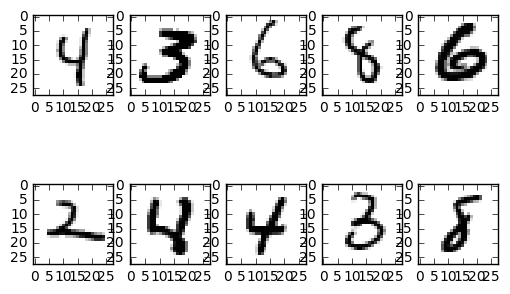

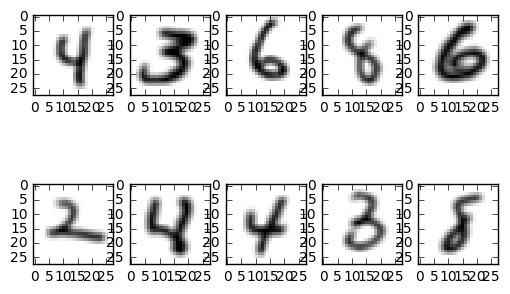

In [27]:
# Compare the blur effect between 10 digits 
print_digits(dev_data[0:10], range(10), 5)
print_digits(blur_dev_data[0:10], range(10), 5)


COMMENT: The Gaussian blur algorithm has the desired effect of blurring the digits. Note these are run on the basis that the 8 neighboring pixels and the original pixel value are simply equally weighted.

No preprocessing of the training or dev data (for comparison).
train sizes:  [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies:  [0.72, 0.786, 0.841, 0.884, 0.902, 0.926, 0.937, 0.959, 0.97]
times:  [0.1126, 0.228, 0.4644, 0.881, 1.7338, 3.5121, 6.9704, 13.5336, 26.9527]

Preprocessed the training data but not the dev data.
train sizes:  [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies:  [0.778, 0.833, 0.863, 0.896, 0.923, 0.947, 0.952, 0.967, 0.977]
times:  [0.1054, 0.2244, 0.4364, 0.9452, 1.8998, 3.904, 7.7752, 15.3714, 29.8353]

Preprocessed the dev data but not the training data.
train sizes:  [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies:  [0.708, 0.78, 0.837, 0.863, 0.88, 0.91, 0.935, 0.958, 0.964]
times:  [0.0977, 0.2098, 0.407, 0.8588, 1.6954, 3.3739, 6.7273, 13.4254, 26.5135]

Preprocessed both training and dev data
train sizes:  [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies:  [0.77, 0.821, 0.866, 0.895, 0.918, 0

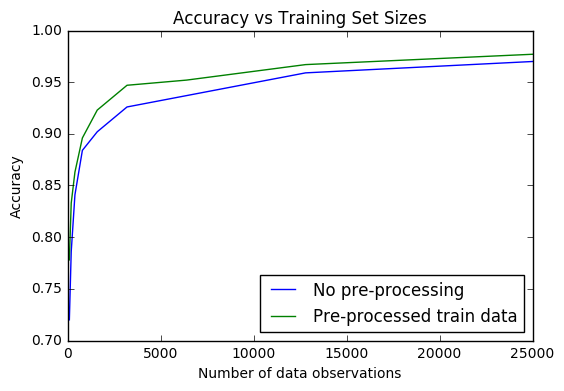

In [28]:
def P6():
    # Re-run P3 results for comparison
    print "No preprocessing of the training or dev data (for comparison)."
    P3_accuracies, P3_times = P3(train_sizes, [])
    print ""
    # Perform 3 scenarios as specified in the question
    # Scenario 0: preprocess the training data but not the dev data
    # Scenario 1: preprocess the dev data but not the training data
    # Scenario 2: preprocess both training and dev data    
    for scenario in range(3):
        # Initialise lists for output results
        accuracies = []
        times = []
        # Perform the scenarios on across the different training size data sets
        for size in train_sizes:
            # Determine samples given scenario and train size
            if scenario in (0,2):
                t_data = blur_train_data[:size]
            else:
                t_data = train_data[:size]
            t_labels = train_labels[:size]
            if scenario == 0: 
                d_data = dev_data
            else:
                d_data = blur_dev_data
            d_labels = dev_labels
            # run classifier given scenario and train size
            clf, stats = run_clf(t_data, t_labels, d_data, d_labels, KNeighborsClassifier, n_neighbors=1)
            # Collate result output
            accuracies.append(stats['accuracy'])
            times.append(round(stats['speed'],4))
        # print ouput
        if scenario == 0:
            print "Preprocessed the training data but not the dev data."
            P6_accuracies = accuracies
        elif scenario == 1:
            print "Preprocessed the dev data but not the training data."
        else:
            print "Preprocessed both training and dev data"            
        print "train sizes: ", train_sizes
        print "accuracies: ", accuracies
        print "times: ", times
        print ""
    # Plot impact of blur 
    line1, = plt.plot(train_sizes, P3_accuracies, label='No pre-processing')
    line2, = plt.plot(train_sizes, P6_accuracies, label='Pre-processed train data')
    plt.title("Accuracy vs Training Set Sizes")
    plt.xlabel("Number of data observations")
    plt.ylabel("Accuracy")
    plt.legend(handles=[line1, line2],loc='lower right')
    plt.show()

P6()


ANSWER: As shown in the chart most benefit from the blurring is gained under the first scenario where the training data is pre-processed and the dev data is not, and particularly so for the smaller train sizes. Intuitively, this seems reasonable in that if the training digits are blurred there will be a greater chance of finding a more similar or nearer neighbor for the actual dev data digits because the dev data digits are more likely to be wholly contained within the blurred digits. While blurring the dev data makes it harder to find similar digits in the training data set because the blurred dev data digits will more than overlap the actual training digits. The double blurring scenario improves upon the unblurred base case, however, not as much as the first scenario, particularly for small train sizes.

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [11]:
# Pre-process data for BernoulliNB
def binarizer(data):
    data = np.where(data > 0, 1, data)
    return data

binarized_mini_data = binarizer(mini_train_data)
binarized_dev_data = binarizer(dev_data)

# Pre-process data for MultinomialNB
# I am sure there is a better way of doing this, but this works nice and quickly
# First convert all 1's to -2's then convert all remaining numbers above 0 to 1's
# and finally convert the -2's to 2's to trinarize the data to all be in [0, 1, 2]
def trinarizer(data, ubound=1):
    data = np.where(data >= ubound, -2, data)
    data = np.where(data > 0, 1, data)
    data = np.where(data == -2, 2, data)
    return data

trinarized_mini_data = trinarizer(mini_train_data)
trinarized_dev_data = trinarizer(dev_data)


In [12]:
def P7():
    # run the Bernoulli classifier with out of the box parameters and binarizing all values above zero to 1
    print "Bernoulli classifier using the binarize argument"
    clf, stats = run_clf(mini_train_data, mini_train_labels, dev_data, dev_labels, BernoulliNB, binarize=0.0)
    print "accuracy: ", stats['accuracy']
    clf_output(stats)
    print "Bernoulli classifier using the pre-binarized data"
    # run the Bernoulli classifier with out of the box parameters using binarized data
    clf, stats = run_clf(binarized_mini_data, mini_train_labels, binarized_dev_data, dev_labels, BernoulliNB)
    print "accuracy: ", stats['accuracy']
    clf_output(stats)
    print "Multinominial classifier using the pre-trinarized data"
    # run the Multinomial classifer with the trinarized data 
    clf, stats = run_clf(trinarized_mini_data, mini_train_labels, trinarized_dev_data, dev_labels, MultinomialNB)
    print "accuracy: ", stats['accuracy']
    clf_output(stats)
    
P7()

Bernoulli classifier using the binarize argument
accuracy:  0.815
Classification report:
             precision    recall  f1-score   support

        0.0       0.88      0.97      0.92        99
        1.0       0.86      0.96      0.91       105
        2.0       0.87      0.78      0.82       102
        3.0       0.63      0.74      0.68        86
        4.0       0.89      0.78      0.83       104
        5.0       0.81      0.63      0.71        91
        6.0       0.87      0.89      0.88        98
        7.0       0.91      0.76      0.83       113
        8.0       0.74      0.77      0.76        96
        9.0       0.72      0.84      0.77       106

avg / total       0.82      0.81      0.81      1000

Confusion matrix:
[[ 96   0   0   1   0   0   2   0   0   0]
 [  0 101   0   0   0   1   1   0   2   0]
 [  4   1  80   6   0   0   2   3   6   0]
 [  0   2   5  64   0   3   2   1   7   2]
 [  0   0   1   0  81   0   3   2   6  11]
 [  3   2   0  19   4  57   3   0   0  

ANSWER: Notably the two Bernoulli classifier approaches produce the same results as expected. Also the Bernoulli classifer produces more accurate predictions than the Multinomial classifier. This is because the gray observations that score a 1 in my trinarizer() function are largely around the perimeter of the digit and are somewhat noisily so across all the digit examples, therefore the additional feature is unlikely to lead to reliably improved predictions.

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [13]:
def P8(alphas):
    # Run a Grid Search on a Bernoulli classifier across various alphas with cross-validation set at 10
    clf = GridSearchCV(BernoulliNB(binarize=0.0),alphas,cv=10)
    clf.fit(mini_train_data, mini_train_labels)
    # print results of the Grid Search
    print "Results of Grid Search:"
    for item in clf.grid_scores_:
        print item
    print ""
    print "Best classifier:"
    print clf.best_estimator_
    print ""
    print "Bernoulli classifier using the binarize argument and best alpha:"
    clf, stats = run_clf(binarized_mini_data, mini_train_labels, binarized_dev_data, dev_labels, BernoulliNB, alpha = 0.0001)
    print "accuracy: ", stats['accuracy']
    clf_output(stats)
    return clf

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)

Results of Grid Search:
mean: 0.09200, std: 0.00213, params: {'alpha': 0.0}
mean: 0.82000, std: 0.03119, params: {'alpha': 0.0001}
mean: 0.81900, std: 0.03181, params: {'alpha': 0.001}
mean: 0.81800, std: 0.03417, params: {'alpha': 0.01}
mean: 0.81700, std: 0.02927, params: {'alpha': 0.1}
mean: 0.81600, std: 0.02912, params: {'alpha': 0.5}
mean: 0.81500, std: 0.02775, params: {'alpha': 1.0}
mean: 0.81200, std: 0.02643, params: {'alpha': 2.0}
mean: 0.78800, std: 0.03438, params: {'alpha': 10.0}

Best classifier:
BernoulliNB(alpha=0.0001, binarize=0.0, class_prior=None, fit_prior=True)

Bernoulli classifier using the binarize argument and best alpha:
accuracy:  0.813
Classification report:
             precision    recall  f1-score   support

        0.0       0.92      0.95      0.94        99
        1.0       0.93      0.93      0.93       105
        2.0       0.75      0.81      0.78       102
        3.0       0.65      0.77      0.70        86
        4.0       0.90      0.75     

ANSWER: The best Laplace smoothing parameter using a cross validation parameter of 10 is 0.0001, i.e. the smallest alpha. However, as the results of the Grid Search show, there is not a huge amount of difference between the mean accuracies for each of the alpha parameters for this example, with the exception of alpha=0. When alpha equals 0 there is no smoothing of the conditional probabilities, which can cause problems when the model comes across an item in the test set not found in the training set and therefore gives it a probability of zero. When dealing with the independence assumptions that underly the Naive Bayes classifier, which involves multiplying the conditional probabilities, the singular zero probability can cause a wildly different results, i.e. multiplying anything by 0 equals 0, for two near similar examples. As a result it is not surprising that the accuracy is smaller than the other results, but I have had no experience with such models before so I am not sure whether the magnitude is overly unusual.

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

accuracy:  0.621
Classification report:
             precision    recall  f1-score   support

        0.0       0.75      0.84      0.79        99
        1.0       0.82      0.89      0.85       105
        2.0       0.62      0.39      0.48       102
        3.0       0.62      0.45      0.52        86
        4.0       0.80      0.39      0.53       104
        5.0       0.52      0.36      0.43        91
        6.0       0.69      0.88      0.77        98
        7.0       0.84      0.48      0.61       113
        8.0       0.41      0.61      0.49        96
        9.0       0.47      0.88      0.61       106

avg / total       0.66      0.62      0.61      1000

Confusion matrix:
[[83  0  3  1  2  6  3  0  1  0]
 [ 0 93  0  1  0  3  2  0  4  2]
 [ 6  2 40 11  2  1 16  1 20  3]
 [ 1  2  5 39  0  3  7  0 21  8]
 [ 4  0  1  1 41  7  9  1 10 30]
 [13  1  4  3  1 33  2  1 25  8]
 [ 0  0  9  0  0  2 86  0  1  0]
 [ 1  0  1  2  2  2  0 54  3 48]
 [ 2 12  2  5  1  7  0  0 59  8]
 [ 0  

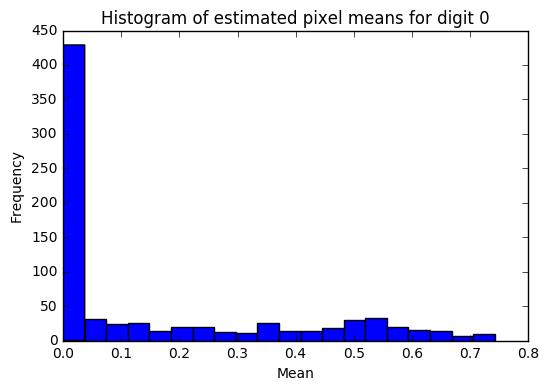

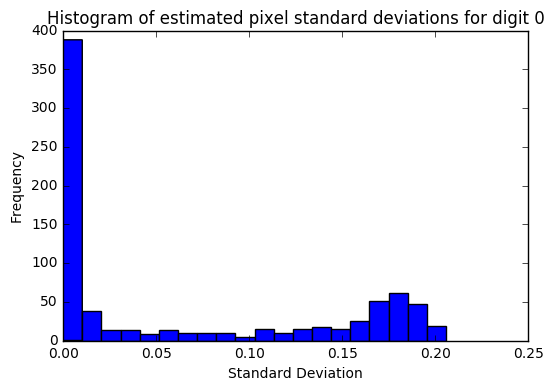

In [14]:
# First run the Gaussian classifier to examine the estimated parameters.
def P9_eda():
    clf, stats = run_clf(mini_train_data, mini_train_labels, dev_data, dev_labels, GaussianNB)
    print "accuracy: ", stats['accuracy']
    clf_output(stats)
    return clf, stats

gnb, stats = P9_eda()
# check histograms of the estimated parameters
plt.hist(gnb.theta_[0],20)
plt.title("Histogram of estimated pixel means for digit 0")
plt.xlabel("Mean")
plt.ylabel("Frequency")
plt.show()
plt.hist(gnb.sigma_[0],20)
plt.title("Histogram of estimated pixel standard deviations for digit 0")
plt.xlabel("Standard Deviation")
plt.ylabel("Frequency")
plt.show()

COMMENT: A first run of the Gaussian classifier produces an accuracy of only 0.621, so not very good on the face of it. As can be seen many of the pixels have a mean value of 0 and because all values for the same pixel causing the 0 mean are 0 consequently the standard deviation of the values is also 0. These models need some variability to create predictions, so we need to make adjustments to the estimated standard deviation parameters, i.e. add some variability. To do so I increase the variability of the estimated parameters that are effectively in the lefthand column of the above chart, i.e. have standard deviations less than 0.02 to be 0.02, i.e. provide some small variability, but not too much so prediction accuracy should remain high.

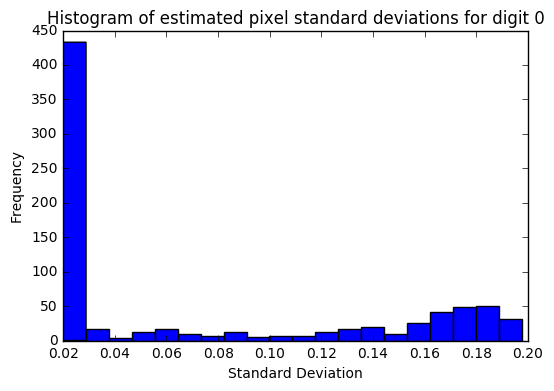

accuracy:  0.835
             precision    recall  f1-score   support

        0.0       0.91      0.97      0.94        99
        1.0       0.89      0.92      0.91       105
        2.0       0.86      0.79      0.83       102
        3.0       0.76      0.74      0.75        86
        4.0       0.88      0.76      0.81       104
        5.0       0.85      0.75      0.80        91
        6.0       0.90      0.92      0.91        98
        7.0       0.95      0.76      0.84       113
        8.0       0.73      0.83      0.78        96
        9.0       0.69      0.89      0.77       106

avg / total       0.84      0.83      0.84      1000

[[96  0  1  0  0  0  1  0  1  0]
 [ 0 97  0  1  0  1  1  0  5  0]
 [ 3  2 81  5  0  1  4  3  3  0]
 [ 0  2  6 64  1  0  1  0  7  5]
 [ 0  0  0  0 79  0  3  0  7 15]
 [ 2  0  2  8  2 68  0  1  2  6]
 [ 1  1  0  0  2  4 90  0  0  0]
 [ 1  3  2  1  2  0  0 86  3 15]
 [ 0  4  2  3  0  5  0  0 80  2]
 [ 2  0  0  2  4  1  0  1  2 94]]


In [15]:
def P9():
    clf, stats = run_clf(train_data, train_labels, dev_data, dev_labels, GaussianNB)
    return clf, stats
    
gnb, stats = P9()
# make adjustment to the estimated parameter model variability
gnb.sigma_ = np.where(gnb.sigma_ < 0.02, 0.02, gnb.sigma_)
# show the new histogram of sigma_
plt.hist(gnb.sigma_[0],20)
plt.title("Histogram of estimated pixel standard deviations for digit 0")
plt.xlabel("Standard Deviation")
plt.ylabel("Frequency")
plt.show()
# recalculate the predictions
predictions = gnb.predict(dev_data)
# calculate accuracy of the new predictions
correct = 0
correct += np.sum(predictions==dev_labels)
total = len(dev_labels)
accuracy = float(correct)/float(total)
# produce a classification report for the new predictions
clf_report = classification_report(dev_labels, predictions)
# produce confusion matrix for the new predictions
confusion = confusion_matrix(dev_labels, predictions)

print "accuracy: ", accuracy
print clf_report
print confusion

ANSWER: Following the adjustment to the standard deviation estimates the accuracy improves significantly.

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

Digit generated:  0


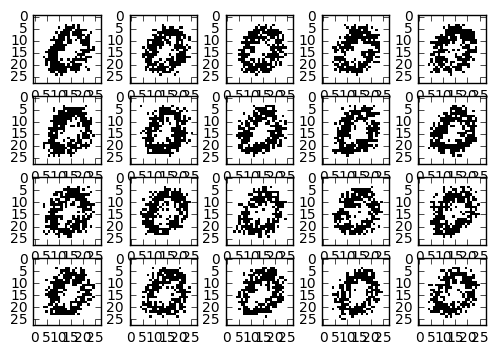

Digit generated:  1


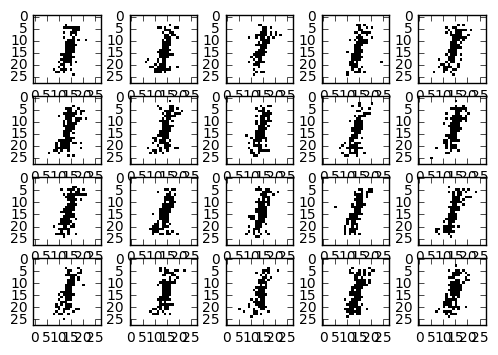

Digit generated:  2


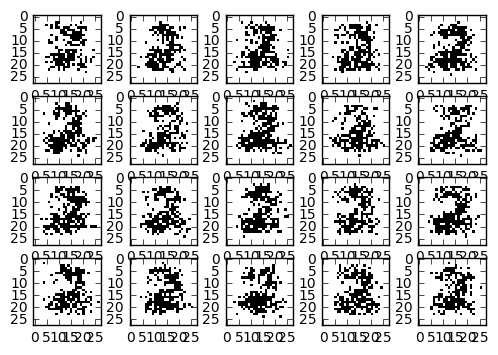

Digit generated:  3


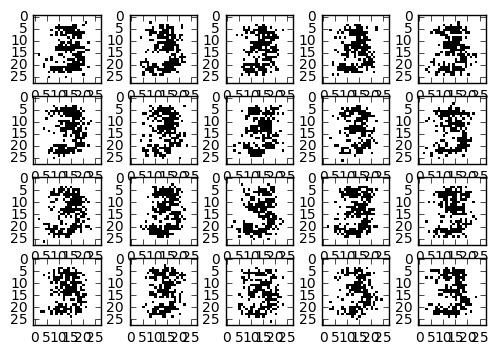

Digit generated:  4


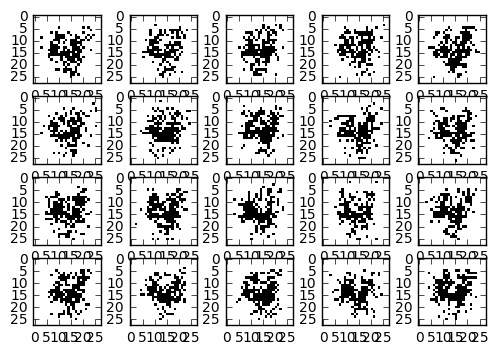

Digit generated:  5


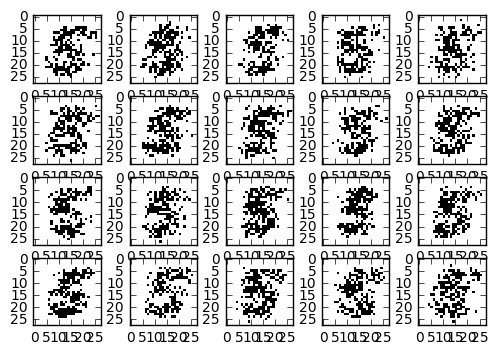

Digit generated:  6


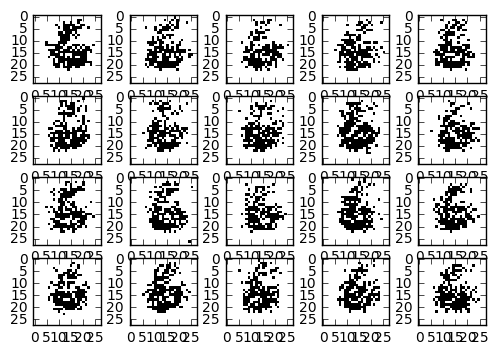

Digit generated:  7


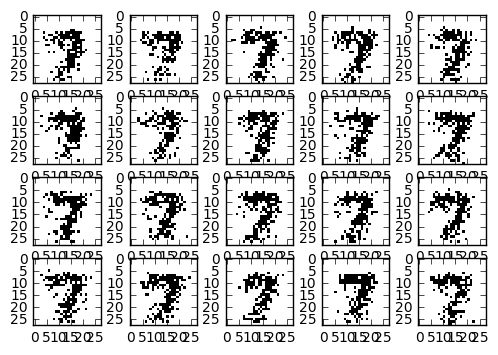

Digit generated:  8


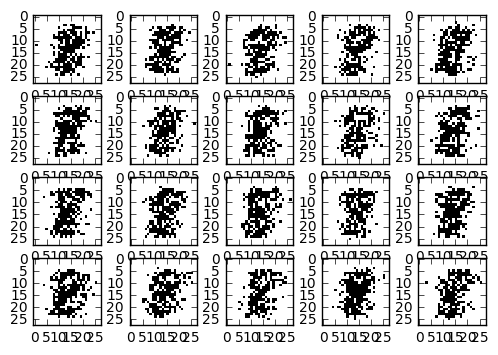

Digit generated:  9


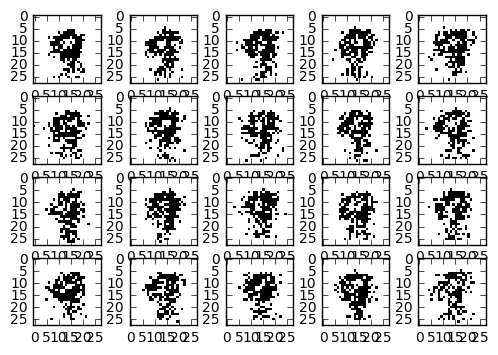

In [16]:
def P10(num_examples):
    # Run the Bernoulli classifier with out of the box parameters and binarizing all values above zero to 1
    clf, stats = run_clf(train_data, train_labels, dev_data, dev_labels, BernoulliNB, binarize=0.0)
    # Collect pixel probabilities from the trained classifier
    probs = np.exp(clf.feature_log_prob_)
    # Randomly generate 'num_examples' of each digit
    for digit in range(10):
        # Create empty list to store the generated digits
        digits = []
        for i in range(num_examples):
            # Retrieve a set of standard uniform random numbers
            rand_digit = np.random.rand(784)
            # Compare random uniform numbers to the probabilities to set pixel values
            rand_digit = np.where(rand_digit < probs[digit], 1, 0)
            digits.append(rand_digit)
        # Convert list to numpy array for use in the generic print_digits function
        digits = np.asarray(digits)
        print "Digit generated: ", digit
        print_digits(digits,range(num_examples),5)
    
P10(20)

ANSWER: Visually you can generally tell what digit each group of generated digits represents, however, the digits are quite pixellated highlighting that this method is not that good as a generation tool. If you assume that many of the the pixels that have a low, but non-zero probability should largely be white, you can make the hurdle harder to turn on the pixel by reducing the probability to zero. For example, the code below changes any probabilities less than 0.5 to 0. When you re-run the code the clarity of the generated digits is much improved, but still of lower quality than the originals. 

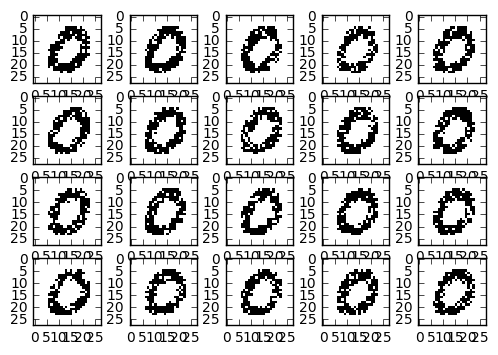

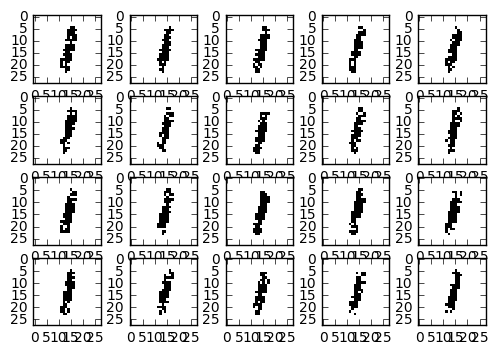

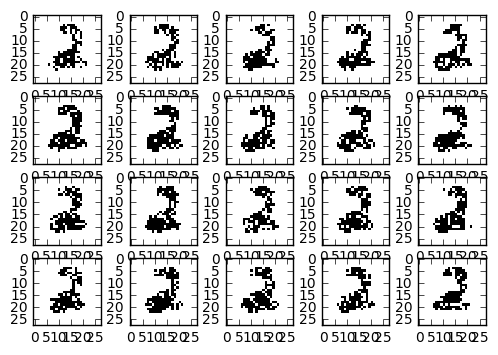

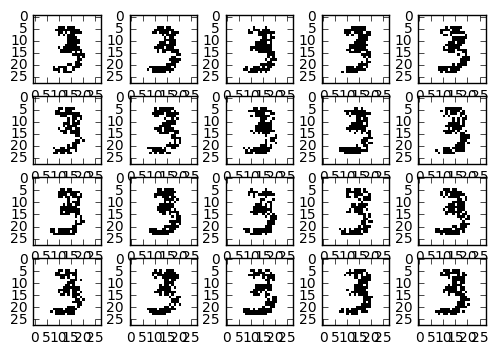

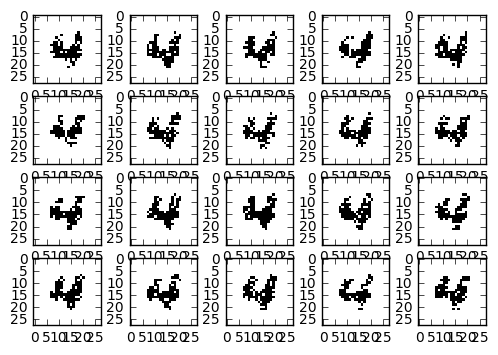

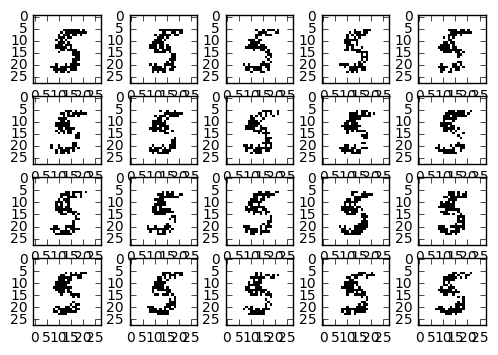

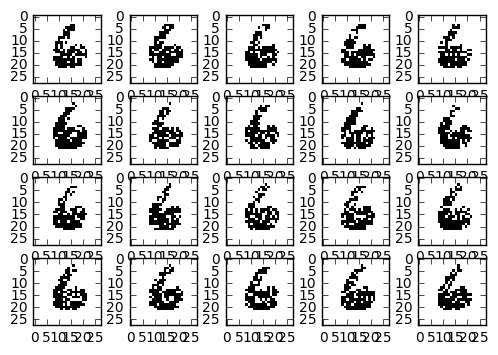

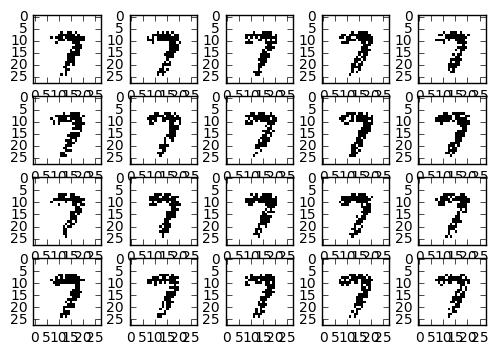

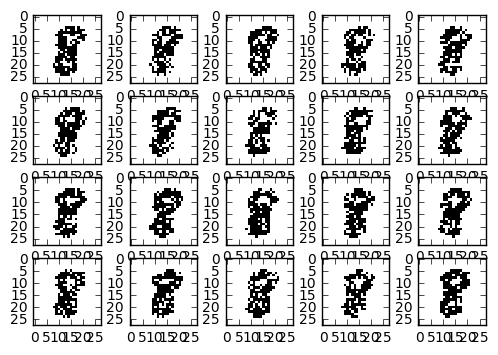

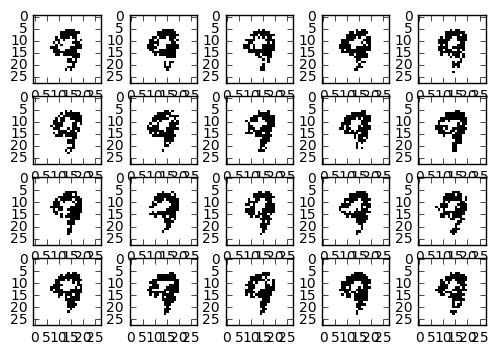

In [17]:
def P10(num_examples):
    # Run the Bernoulli classifier with out of the box parameters and binarizing all values above zero to 1
    clf, stats = run_clf(train_data, train_labels, dev_data, dev_labels, BernoulliNB, binarize=0.0)
    # Collect pixel probabilities from the trained classifier
    probs = np.exp(clf.feature_log_prob_)
    # Change probability hurdle to cause more white pixels, when estimated probability is low
    probs = np.where(probs<0.5, 0,probs)
    # Randomly generate 'num_examples' of each digit
    for digit in range(10):
        # Create empty list to store the generated digits
        digits = []
        for i in range(num_examples):
            # Retrieve a set of standard uniform random numbers
            rand_digit = np.random.rand(784)
            # Compare random uniform numbers to the probabilities to set pixel values
            rand_digit = np.where(rand_digit < probs[digit], 1, 0)
            digits.append(rand_digit)
        # Convert list to numpy array for use in the generic print_digits function
        digits = np.asarray(digits)
        print_digits(digits,range(num_examples),5)
    
P10(20)

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [18]:
def P11(buckets, correct, total):
    # Run the Bernoulli classifier with out of the box parameters, binarized data and alpha=0.0001
    clf, stats = run_clf(binarized_mini_data, mini_train_labels, binarized_dev_data, dev_labels, BernoulliNB, alpha=0.0001)
    # Collect predicted probabilities by digit class
    probs = clf.predict_proba(dev_data)
    # Collect digit predictions
    preds = clf.predict(dev_data)
    # Rename actual labels
    actuals = dev_labels
    # Iterate through the probabilities to find the maximum class probability
    for i in range(probs.shape[0]):
        max_prob = np.max(probs[i])
        correct_pred = preds[i]==actuals[i]
        for j in range(len(buckets)):
            # Find posterior buckets that max_prob[i] is in 
            if max_prob <= buckets[j]:
                # Increase correct count if the prediction is correct
                if correct_pred:
                    correct[j] += 1
                # Increase total if max_prob[i] is in the posterior bucket
                total[j] += 1
    # Print accuracy report
    for i in range(len(buckets)):
        accuracy = 0.0
        if total[i] > 0:
            accuracy = float(correct[i]) / float(total[i])
        print 'p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy)

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]
P11(buckets, correct, total)



p(pred) <= 0.5000000000000    total =   1    accuracy = 0.000
p(pred) <= 0.9000000000000    total =  35    accuracy = 0.457
p(pred) <= 0.9990000000000    total =  94    accuracy = 0.426
p(pred) <= 0.9999900000000    total = 153    accuracy = 0.464
p(pred) <= 0.9999999000000    total = 212    accuracy = 0.500
p(pred) <= 0.9999999990000    total = 253    accuracy = 0.502
p(pred) <= 0.9999999999900    total = 303    accuracy = 0.535
p(pred) <= 0.9999999999999    total = 343    accuracy = 0.563
p(pred) <= 1.0000000000000    total = 1000    accuracy = 0.813


ANSWER: Ideally average accuracy of the classifier should be in line with the posterior bucket level to be strongly calibrated, i.e. for example the accuracy of p(pred) < 0.9 should equal 0.9. As can be seen in the table above the accuracies are much lower than the posteriors, particularly for the lower posteriors, so the classifier is only weakly calibrated, i.e. it only becomes more accurate the higher the posterior. 

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [19]:
def add_rows_cols(data):
    # Add row and column sums to data
    new_data = []
    for d in range(data.shape[0]):
        digit = data[d].reshape(28,28)
        cols = [sum(digit[:,j])/28 for j in range(28)]
        rows = [sum(digit[j,:])/28 for j in range(28)]
        new_features = np.append(rows,cols)
        new_data.append(np.append(data[d],new_features))
    new_data = np.asarray(new_data)
    print new_data.shape
    return new_data
    
EC_md = add_rows_cols(mini_train_data)
EC_dd = add_rows_cols(dev_data)
EC_td = add_rows_cols(test_data)

(1000, 840)
(1000, 840)
(9000, 840)


COMMENT: Please note I tried (above) including the sum of the grayscale values by row and column, but didn't find that this improved the accuracy of the Naive Bayes classifier. I suspect that this is because the sum of the grayscale values on a row or column is a simple linear function of the pixels in that row or column, which are already included in the original 784 features. So given the independence assumptions and hence multiplcative probabilities underlying Naive Bayes it seems that sums of rows and columns may just be doubling up on existing features and hence adding no major value to improve overall accuracy. on this basis it makes more sense that additional features that are not linear combinations of existing features may prove to be better inclusions, i.e. the number of enclosed areas. 

NEXT STAGE: I was not able to think of a nifty way to count the number of enclosed areas, so I instead thought about the intuition of what the aim of doing this was trying to achieve. Accordingly, I thought if you binarized the data and then effectively checked how many consecutive groups of 0's or 1's there are in each row and column this will crudely isolate enclosed areas. For example, on a row in the middle of the digit 1 there will be a series of 0's, a series of 1's and then a series of 0's. Whereas an 8 on a row cutting through the top or bottom circle will have two series of 1's and three series of 0's. So I have programmed this up below. Most importantly I am looking for rows or columns where there are at least 2 distinct sets of 1's, so I binarize for results 2 or more sets of 1's. Importantly, these results are not a linear combination of the existing features. 

In [20]:
def add_num_changes(data):
    # calculate home many changes in adjacent digits occur on each row
    new_data = []
    for d in range(data.shape[0]):
        digit = data[d][:784].reshape(28,28)
        digit = np.where(digit==0,0,1)
        cols = []
        for i in range(28):
            changes = 0
            for j in range(1,28):
                if digit[:,i][j] != digit[:,i][j-1]:
                    changes += 1
            cols.append(changes)
        rows = []
        for i in range(28):
            changes = 0
            for j in range(1,28):
                if digit[i,:][j] != digit[i,:][j-1]:
                    changes += 1
            rows.append(changes)
        new_features = np.append(rows,cols)
        # binarize the number of change yielding 1 for two or more
        new_features = [float((i // 4)) for i in new_features]
        new_data.append(binarizer(np.append(data[d],new_features)))
    new_data = np.asarray(new_data)
    print new_data.shape
    return new_data
        
# EC_td = add_num_changes(EC_td)
# EC_dd = add_num_changes(EC_dd)
# EC_md = add_num_changes(EC_md)

EC_td = add_num_changes(test_data)
EC_dd = add_num_changes(dev_data)
EC_md = add_num_changes(mini_train_data)



(9000, 840)
(1000, 840)
(1000, 840)


In [21]:
def P12():
    # run the Bernoulli classifier on old features only
    clf, stats = run_clf(binarizer(mini_train_data), mini_train_labels, binarizer(dev_data), dev_labels, BernoulliNB, alpha=0.0001)
    print "accuracy: ", stats['accuracy']
    clf_output(stats)

    # run the Bernoulli classifier on old and features
    clf, stats = run_clf(EC_md, mini_train_labels, EC_dd, dev_labels, BernoulliNB, alpha=0.0001)
    print "accuracy: ", stats['accuracy']
    clf_output(stats)

P12()


accuracy:  0.813
Classification report:
             precision    recall  f1-score   support

        0.0       0.92      0.95      0.94        99
        1.0       0.93      0.93      0.93       105
        2.0       0.75      0.81      0.78       102
        3.0       0.65      0.77      0.70        86
        4.0       0.90      0.75      0.82       104
        5.0       0.76      0.67      0.71        91
        6.0       0.89      0.88      0.88        98
        7.0       0.92      0.77      0.84       113
        8.0       0.72      0.76      0.74        96
        9.0       0.72      0.82      0.77       106

avg / total       0.82      0.81      0.81      1000

Confusion matrix:
[[94  0  2  1  0  1  1  0  0  0]
 [ 0 98  0  0  0  2  1  0  4  0]
 [ 3  1 83  7  0  0  2  2  4  0]
 [ 0  1  7 66  0  2  1  1  5  3]
 [ 0  0  2  0 78  2  3  2  6 11]
 [ 3  0  1 18  3 61  3  0  1  1]
 [ 0  1  8  0  1  2 86  0  0  0]
 [ 1  1  2  0  2  3  0 87  4 13]
 [ 1  3  2  7  0  5  0  0 73  5]
 [ 0  

In [22]:
# Re-run Q11 on the old and new features
def P11(buckets, correct, total):
    # Run the Bernoulli classifier with out of the box parameters, binarized data and alpha=0.0001 on th
    clf, stats = run_clf(EC_md, mini_train_labels, EC_dd, dev_labels, BernoulliNB, alpha=0.0001)
    # Collect predicted probabilities by digit class
    probs = clf.predict_proba(EC_dd)
    # Collect digit predictions
    preds = clf.predict(EC_dd)
    # Rename actual labels
    actuals = dev_labels
    # Iterate through the probabilities to find the maximum class probability
    for i in range(probs.shape[0]):
        max_prob = np.max(probs[i])
        correct_pred = preds[i]==actuals[i]
        for j in range(len(buckets)):
            # Find posterior buckets that max_prob[i] is in 
            if max_prob <= buckets[j]:
                # Increase correct count if the prediction is correct
                if correct_pred:
                    correct[j] += 1
                # Increase total if max_prob[i] is in the posterior bucket
                total[j] += 1
    # Print accuracy report
    for i in range(len(buckets)):
        accuracy = 0.0
        if total[i] > 0:
            accuracy = float(correct[i]) / float(total[i])
        print 'p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy)

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]
P11(buckets, correct, total)

p(pred) <= 0.5000000000000    total =   0    accuracy = 0.000
p(pred) <= 0.9000000000000    total =  28    accuracy = 0.571
p(pred) <= 0.9990000000000    total =  83    accuracy = 0.446
p(pred) <= 0.9999900000000    total = 126    accuracy = 0.476
p(pred) <= 0.9999999000000    total = 183    accuracy = 0.519
p(pred) <= 0.9999999990000    total = 219    accuracy = 0.534
p(pred) <= 0.9999999999900    total = 260    accuracy = 0.554
p(pred) <= 0.9999999999999    total = 298    accuracy = 0.584
p(pred) <= 1.0000000000000    total = 1000    accuracy = 0.837


COMMENT: By including these new features that are additive to the exisiting features the results show an expected 2.4% improvement in accuracy.